In [10]:
"""
Visualization of single neuron dynamics for various models
"""
import numpy as np
import matplotlib.pyplot as plt
import neuron
import scipy as sp



# also define figure paramaters
plt.rcParams['xtick.major.size']=6.0#7.0
plt.rcParams['ytick.major.size']=6.0#7.0
plt.rcParams['xtick.major.width']=2.0#2.5
plt.rcParams['ytick.major.width']=2.0#2.5
plt.rcParams['text.usetex'] = True
#plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 20 #15
plt.rcParams['legend.fontsize'] = 18 #14
plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['errorbar.capsize'] = 4.0

#normalized guassian for constructing input signals
Gaussian_pulse= lambda x, mu, sig: np.exp(-np.power(x - mu, 2.) 
    / (2 * np.power(sig, 2.)))/(np.sqrt(2*np.pi)*sig)

Section 1: Yamada laser neuron dynamics under excitation

Demo of Yamada Neuron response to pulsed inputs


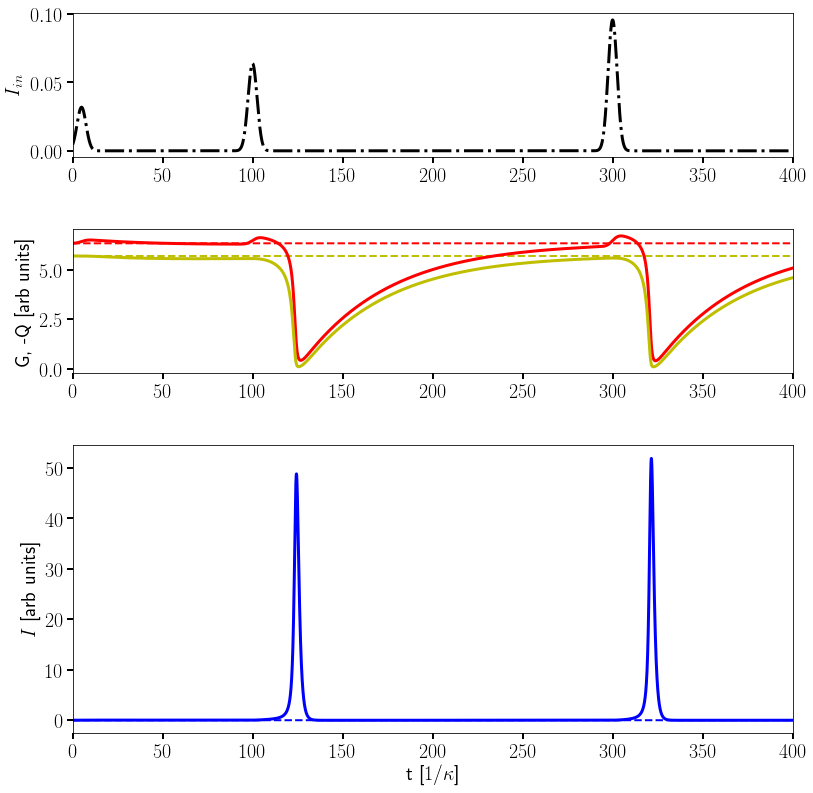

In [12]:
#Demo of spiking Yamada Neuron (version1)
#only spikes for inputs with pulse area >threshold

#Create Neuron, best to choose kappa=1 so gamma[kappa] and time[1/kappa]
Y1mpars={"a": 2, "A": 6.5, "B":-6., "gamma1": 2e-2,
         "gamma2": 2e-2, "kappa": 1, "beta": 1e-2 }

y1_steady_est=[Y1mpars['beta']/Y1mpars['kappa'],
               Y1mpars['A'],Y1mpars['B'] ]
Y1params={"model" : "Yamada_1", "y0": y1_steady_est,
    "dt": 5.e-2, 'mpar': Y1mpars} #quick estimate of ss
Y1Neuronv1=neuron.Neuron(Y1params)
y1_steady=Y1Neuronv1.steady_state(y1_steady_est)
#Reinitialize Neuron with this state
Y1params["y0"]=y1_steady
Y1Neuronv1=neuron.Neuron(Y1params)

#create time signal, set params in terms of gamma1
t1_end=8./Y1mpars["gamma1"]; #atleast this long
N1=int(np.ceil(t1_end/Y1Neuronv1.dt)) #this many points
time1=np.linspace(0.,(N1-1)*Y1Neuronv1.dt, num=N1 )

#choose gaussian input
x1=np.zeros(N1)
x1+=0.2*Gaussian_pulse(time1, 0.1/Y1mpars["gamma1"], 5.e-2/Y1mpars["gamma1"])
x1+=0.4*Gaussian_pulse(time1, 2./Y1mpars["gamma1"], 5.e-2/Y1mpars["gamma1"])
x1+=0.6*Gaussian_pulse(time1, 6./Y1mpars["gamma1"], 5.e-2/Y1mpars["gamma1"])
#solve and estimate steady state
y1v1_out=Y1Neuronv1.solve(x1)

# Plot 
fig=plt.figure(figsize=(10,10))
ax1=fig.add_axes([0,0, 1, 0.4])
ax2=fig.add_axes([0,0.5, 1, 0.2])
ax3=fig.add_axes([0,.8, 1, 0.2])


# plot steady states
ax1.plot(time1, y1_steady[0]*np.ones(N1), 'b--', linewidth=2)
ax2.plot(time1, y1_steady[1]*np.ones(N1), 'r--', linewidth=2)
ax2.plot(time1, -y1_steady[2]*np.ones(N1), 'y--', linewidth=2)
# plot Neuron state and input current
ax1.plot(time1, y1v1_out[:,0], 'b-')
ax2.plot(time1, y1v1_out[:,1], 'r-')
ax2.plot(time1, -y1v1_out[:,2], 'y-')
ax3.plot(time1, x1, 'k-.')

ax1.set_xlabel('t [$1/\kappa$]')
ax1.set_ylabel('$I$ [arb units]')
ax2.set_ylabel('G, -Q [arb units]')
ax3.set_ylabel('$I_{in}$')

ax1.set_xlim(time1[0], time1[-1])
ax2.set_xlim(time1[0], time1[-1])
ax3.set_xlim(time1[0], time1[-1])

# fig.show()
print("Demo of Yamada Neuron response to pulsed inputs")

Demo of Yamada Neuron response to constant inputs


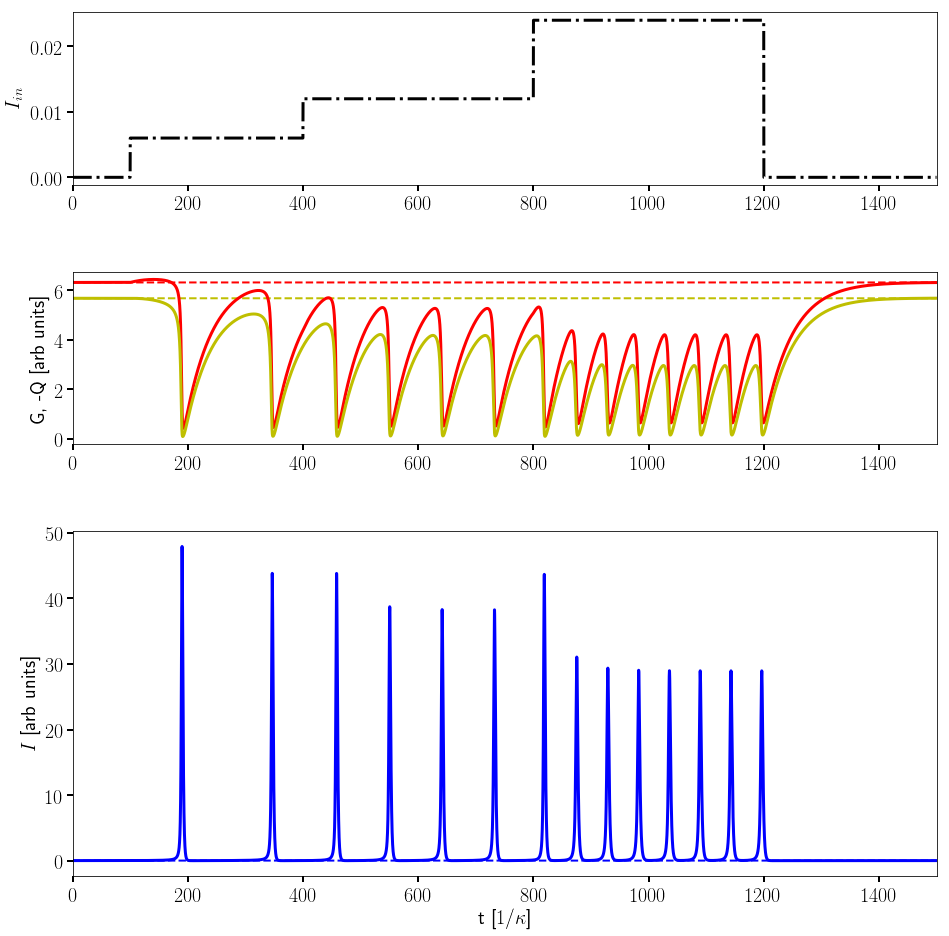

In [11]:
# study same neuron as above,
# but now drive with constant signals to see self pusling

Y1Neuronv2=neuron.Neuron(Y1params)

#create time signal
t2_end=30/Y1mpars["gamma1"]; #atleast this long
N2=int(np.ceil(t2_end/Y1Neuronv2.dt))
time2=np.linspace(0.,(N2-1)*Y1Neuronv2.dt, num=N2 )

#create steps out of heavisides
x2=np.zeros(N2)
#scale with gamma1 so drive in units of A
x2+=(0.3*Y1mpars["gamma1"])*np.heaviside(time2-2./Y1mpars["gamma1"], 0.5)
x2+=(0.3*Y1mpars["gamma1"])*np.heaviside(time2-8./Y1mpars["gamma1"], 0.5)
x2+=(0.6*Y1mpars["gamma1"])*np.heaviside(time2-16./Y1mpars["gamma1"], 0.5)
x2+=-(1.2*Y1mpars["gamma1"])*np.heaviside(time2-24./Y1mpars["gamma1"], 0.5)

#solve and estimate steady state
y1v2_out=Y1Neuronv2.solve(x2)

#plot
fig2=plt.figure(figsize=(10,10))
ax1=fig2.add_axes([0,0, 1, 0.4])
ax2=fig2.add_axes([0,0.5, 1, 0.2])
ax3=fig2.add_axes([0,.8, 1, 0.2])

# plot steady states
ax1.plot(time2, y1_steady[0]*np.ones(N2), 'b--', linewidth=2)
ax2.plot(time2, y1_steady[1]*np.ones(N2), 'r--', linewidth=2)
ax2.plot(time2, -y1_steady[2]*np.ones(N2), 'y--', linewidth=2)
# plot Neuron state and input current
ax1.plot(time2, y1v2_out[:,0], 'b-')
ax2.plot(time2, y1v2_out[:,1], 'r-')
ax2.plot(time2, -y1v2_out[:,2], 'y-')
ax3.plot(time2, x2, 'k-.')

ax1.set_xlabel('t [$1/\kappa$]')
ax1.set_ylabel('$I$ [arb units]')
ax2.set_ylabel('G, -Q [arb units]')
ax3.set_ylabel('$I_{in}$')

ax1.set_xlim(time2[0], time2[-1])
ax2.set_xlim(time2[0], time2[-1])
ax3.set_xlim(time2[0], time2[-1])

# fig.show()
print("Demo of Yamada Neuron response to constant inputs")

Section 2: Dynamics of integrated laser neuron (simplified Yamada model)

In [ ]:
#Demo of integrated laser Neuron (version 0)
#again, only spikes for inputs with pulse area >threshold

